# Experiment 1

Checking whether a heap-like graph is actually a heap using a GGNN

In [7]:
%cd ..
%pwd
import wandb
from experiments.heaps import *
from ggnns.graph_level_ggnn import GraphLevelGGNN
from experiments.utils import *
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt

/home/tekne/Oxford/ATML/Project


In [8]:
PROJECT_NAME="ggnn_heap_check"

In [9]:
def get_data(config):
    if config["graph_kind"] == 'tree':
        graph_generators = [(heap_graph, True)]
    elif config["graph_kind"] == 'linear':
        graph_generators = [(directed_path_graph, True)]
    elif config["graph_kind"] == 'linear+tree':
        graph_generators = [(heap_graph, True), (directed_path_graph, True)]
    else:
        raise ValueError(f"config[\"graph_kind\"] = {config.graph_kind}")

    data = make_heap_test_gnn_datapoints(
        n = config["n_train"] + config["n_test"],
        p_heap = config["p_heap"],
        min_len = config["min_len"],
        max_len = config["max_len"],
        graph_generators = graph_generators,
    )

    training_data = DataLoader(data[:config["n_train"]], batch_size=config["batch_size"])
    testing_data = DataLoader(data[config["n_train"]:], batch_size=config["batch_size"])

    return training_data, testing_data

def make_model(config):
    NUM_CLASSES = 2
    return GraphLevelGGNN(
        annotation_size=1,
        num_layers=config["num_layers"],
        gate_nn=nn.Linear(2 * 1 + config["hidden_size"], 1),
        hidden_size=config["hidden_size"],
        final_layer=nn.Linear(2 * 1 + config["hidden_size"], NUM_CLASSES),
    ).cuda()

def run_model(config, logger=wandb):
    model = make_model(config)

    if logger is not None:
        logger.watch(model)
        logger.run.summary["model_parameters"] = model.count_parameters()

    opt = torch.optim.Adam(model.parameters(), lr=config["lr"])
    loss = torch.nn.CrossEntropyLoss()

    training_data, testing_data = get_data(config)

    results = train(
        model=lambda batch: model(batch.x.cuda(), batch.edge_index.cuda(), batch.batch.cuda()),
        opt=opt,
        training_data=training_data,
        testing_data=testing_data,
        criterion=lambda out, batch: loss(out, batch.y.cuda()),
        checker=lambda out, batch: (int((torch.argmax(out, dim=-1) == batch.y.cuda()).sum()), batch.y.shape[0]),
        epochs=config["epochs"],
        logger=logger
    )

    plt.plot(results["train_loss"], label="Training loss")
    plt.plot(results["test_loss"], label="Testing loss")
    plt.legend()
    plt.show()

    plt.plot(results["train_accuracy"], label="Training accuracy")
    plt.plot(results["test_accuracy"], label="Testing accuracy")
    plt.legend()
    plt.show()

def evaluate_model(config, **kwargs):
    wandb.init(**kwargs)
    wandb.config = config

    run_model(wandb.config)

    wandb.finish()

In [10]:
config = {
    "n_train": 1000,
    "n_test": 1000,
    "epochs": 100,
    "lr": 0.01,
    "opimizer": "adam",
    "min_len": 1,
    "max_len": 64,
    "batch_size": 500,
    "p_heap": 0.5,
    "graph_kind": "tree",
    "num_layers": 2,
    "hidden_size": 10,
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tekne (use `wandb login --relogin` to force relogin)
/home/tekne/.local/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


100%|██████████| 100/100 [00:09<00:00, 10.54it/s]


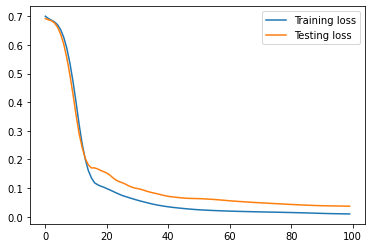

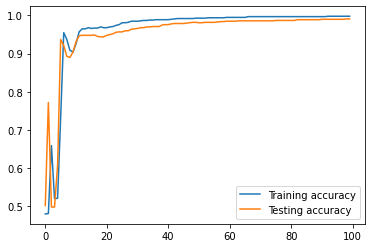

model_parameters,1073
train_loss,0.00978
train_accuracy,0.998
_runtime,13
_timestamp,1617931752
_step,199
test_loss,0.03678
test_accuracy,0.991


train_loss,███▇▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▇▇███████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,██▇▇▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁▁▇▇▇▇▇▇▇▇██████████████████████████████


In [5]:
evaluate_model(config, project=PROJECT_NAME)

In [5]:
config["graph_kind"] = "linear"

100%|██████████| 100/100 [00:09<00:00, 10.82it/s]


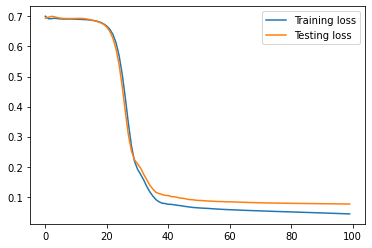

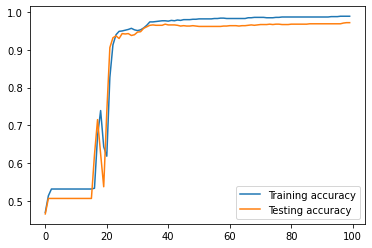

model_parameters,1073
train_loss,0.04276
train_accuracy,0.989
_runtime,10
_timestamp,1617909554
_step,199
test_loss,0.0756
test_accuracy,0.972


train_loss,█████████▇▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▂▂▂▂▂▄▃▇▇█▇███████████████████████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█████████▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁▂▂▂▂▂▂▄▅▇██████████████████████████████


In [6]:
evaluate_model(config, project=PROJECT_NAME)

In [7]:
config["graph_kind"] = "linear+tree"

100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


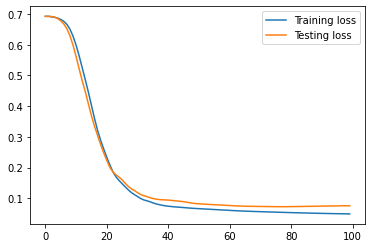

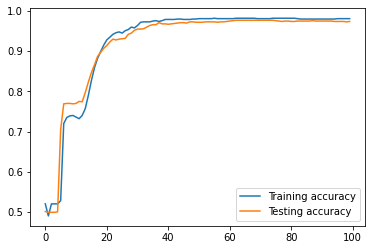

model_parameters,1073
train_loss,0.04927
train_accuracy,0.981
_runtime,11
_timestamp,1617909583
_step,199
test_loss,0.07583
test_accuracy,0.974


train_loss,████▇▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▁▄▄▄▆▆▇▇▇█████████████████████████████
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,████▇▆▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁▁▄▅▅▅▆▇▇▇▇▇████████████████████████████


In [8]:
evaluate_model(config, project=PROJECT_NAME)

In [11]:
sweep_config = {
    "name": "Bayesian sweep",
    "method": "bayes",
    "metric": {
        "name": "test_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {
            "distribution": "constant",
            "value": 100
        },
        "n_train": {
            "distribution": "int_uniform",
            "min": 50,
            "max": 5000,
        },
        "n_test": {
            "distribution": "constant",
            "value": 1000
        },
        "lr": {
            "distribution": "normal",
            "mu": 0.01,
            "sigma": 0.002
        },
        "optimizer": {
            "distribution": "constant",
            "value": "adam"
        },
        "min_len": {
            "distribution": "constant",
            "value": 1
        },
        "max_len": {
            "distribution": "int_uniform",
            "min": 32,
            "max": 128
        },
        "batch_size": {
            "distribution": "constant",
            "value": 500
        },
        "p_heap": {
            "distribution": "uniform",
            "min": 0.4,
            "max": 0.6
        },
        "graph_kind": {
            "distribution": "categorical",
            "values": ["tree", "linear", "linear+tree"]
        },
        "num_layers": {
            "distribution": "int_uniform",
            "min": 1,
            "max": 4,
        },
        "hidden_size": {
            "distribution": "int_uniform",
            "min": 0,
            "max": 50
        },
    },
    "project": "ggnn_heap_check"
}

In [12]:
sweep_id = wandb.sweep(sweep_config, project="tester")

Create sweep with ID: noqkknn7
Sweep URL: https://wandb.ai/tekne/tester/sweeps/noqkknn7


In [16]:
def run_sweep():
    run = wandb.init()
    run_model(run.config)

In [17]:
wandb.agent(sweep_id, function=run_sweep, project="tester")

wandb: Agent Starting Run: d4ye59w6 with config:
wandb: 	batch_size: 500
wandb: 	epochs: 100
wandb: 	graph_kind: linear+tree
wandb: 	hidden_size: 14
wandb: 	lr: 0.012360868358664031
wandb: 	max_len: 67
wandb: 	min_len: 1
wandb: 	n_test: 1000
wandb: 	n_train: 2982
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	p_heap: 0.5420371931550185
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 29%|██▉       | 29/100 [00:06<00:16,  4.40it/s]
